In [27]:
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from collections import Counter
import joblib
import re
import string
import os
# from imblearn.over_sampling import RandomOverSampler
from gensim.models import KeyedVectors
import nltk
nltk.download('stopwords')
from scipy.sparse import hstack
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Data:

In [4]:
trainStances = pd.read_csv('train_stances.csv')
trainBodies = pd.read_csv('train_bodies.csv')
testStances = pd.read_csv('competition_test_stances.csv')
testBodies = pd.read_csv('competition_test_bodies.csv')

In [5]:
trainSet = pd.merge(trainStances, trainBodies, on="Body ID")
testSet = pd.merge(testStances, testBodies, on="Body ID")

In [6]:
trainSet.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\n\n...
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\n\n...


In [7]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
wholeText = np.append(trainSet['Headline'].unique(), trainSet['articleBody'].unique())
vectorizer.fit(wholeText)
joblib.dump(vectorizer, 'UnrelatedVsOthersVectorizer')

['UnrelatedVsOthersVectorizer']

In [8]:
vectorizer = joblib.load("UnrelatedVsOthersVectorizer")

### Training On Unrelated vs Others (Agree, Disagree, Discuss) :

In [9]:
def convertToRequired(x):
  x['headTFIDF'] = vectorizer.transform(x['Headline']).toarray().tolist()
  x['articleBodyTFIDF'] = vectorizer.transform(x['articleBody']).toarray().tolist()
  del(x['Headline'])
  del(x['articleBody'])

  p = x['headTFIDF'].tolist()
  q = x['articleBodyTFIDF'].tolist()
  del(x['headTFIDF'])
  del(x['articleBodyTFIDF'])

  # Calculate distances between headline TFIDF and Body TFIDF
  cos = []
  euc = []
  man = []
  hav = []
  for idx, _ in enumerate(p):
    cos.append(cosine_similarity( [p[idx]], [q[idx]])[0][0])
    euc.append(euclidean_distances( [p[idx]], [q[idx]])[0][0])
    man.append(manhattan_distances( [p[idx]], [q[idx]])[0][0])
  x['cos_simil'] = cos
  x['euclidean'] = euc
  x['manhattan'] = man

  del(cos)
  del(euc)
  del(man)
  del(hav)

  # Map to 0(unrelated) and 1(others - agree, disagree, discuss) only
  x['Stance'] = x['Stance'].map({'agree': 1, 'disagree': 1, 'discuss': 1, 'unrelated': 0})

  return x

In [10]:
trainSet = convertToRequired(trainSet)
testSet = convertToRequired(testSet)

In [11]:
trainSet.to_csv('UnrelatedVsOthersTrain.csv')
testSet.to_csv('UnrelatedVsOthersTest.csv')

In [12]:
trainSet = pd.read_csv('UnrelatedVsOthersTrain.csv')
testSet = pd.read_csv('UnrelatedVsOthersTest.csv')

In [13]:
X_train = trainSet[['cos_simil', 'euclidean', 'manhattan']]
y_train = trainSet['Stance']

In [14]:
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw = dict(enumerate(cw))

#### Logistic Regression

In [15]:
LR = LogisticRegression(class_weight=cw)
LR.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.6837050212067314, 1: 1.860877336709615})

In [16]:
preds = LR.predict(testSet[['cos_simil', 'euclidean', 'manhattan']])
f1_score(testSet['Stance'], preds)

0.7551626693717847

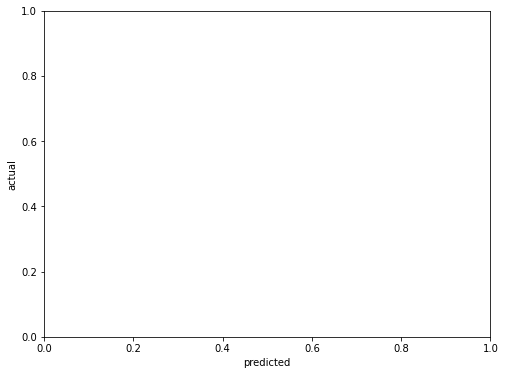

In [18]:
cwMat = confusion_matrix(testSet['Stance'], preds, labels = [0, 1])
cwDf = pd.DataFrame(cwMat, index=["unrelated", "others"], columns=["unrelated", "others"])
plt.figure(figsize=(8,6))
# sns.heatmap(cwDf, annot=True, fmt="d")
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

#### MLP:

In [19]:
model = Sequential()
model.add(Dense(50, input_dim=3, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
new_y_train = to_categorical(y_train)

In [21]:
model.fit(X_train, new_y_train, epochs = 15, validation_split=0.2, class_weight=cw)

Epoch 1/15
1250/1250 [==============================] - 3s 1ms/step - loss: 0.2410 - accuracy: 0.9399 - val_loss: 0.1551 - val_accuracy: 0.9513
Epoch 2/15
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1308 - accuracy: 0.9649 - val_loss: 0.1530 - val_accuracy: 0.9488
Epoch 3/15
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1282 - accuracy: 0.9633 - val_loss: 0.1675 - val_accuracy: 0.9500
Epoch 4/15
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1274 - accuracy: 0.9625 - val_loss: 0.1486 - val_accuracy: 0.9507
Epoch 5/15
1250/1250 [==============================] - 2s 1ms/step - loss: 0.1270 - accuracy: 0.9628 - val_loss: 0.1472 - val_accuracy: 0.9520
Epoch 6/15
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1261 - accuracy: 0.9624 - val_loss: 0.1687 - val_accuracy: 0.9459
Epoch 7/15
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1267 - accuracy: 0.9620 - val_loss: 0.1468 - val_accuracy:

In [26]:
# joblib.dump(model, "UnrelatedVsOthersModel")
model.save('uVSo.h5')

In [28]:
# model1 = joblib.load("UnrelatedVsOthersModel")

In [29]:
preds = model.predict(testSet[['cos_simil', 'euclidean', 'manhattan']])

In [30]:
preds = [np.argmax(x) for x in preds]

In [31]:
f1_score(testSet['Stance'], preds)

0.773655192966771

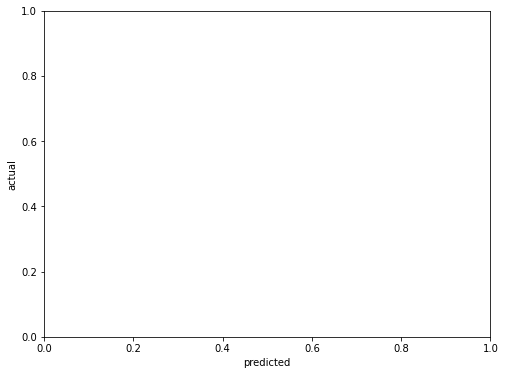

In [33]:
cwMat = confusion_matrix(testSet['Stance'], preds, labels = [0, 1])
cwDf = pd.DataFrame(cwMat, index=["unrelated", "others"], columns=["unrelated", "others"])
plt.figure(figsize=(8,6))
# sns.heatmap(cwDf, annot=True, fmt="d")
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

### Training Between Other 3 Classes:

### MLP:

In [34]:
trainStances = pd.read_csv('train_stances.csv')
trainBodies = pd.read_csv('train_bodies.csv')
testStances = pd.read_csv('competition_test_stances.csv')
testBodies = pd.read_csv('competition_test_bodies.csv')

In [35]:
trainSet = pd.merge(trainStances, trainBodies, on="Body ID")
testSet = pd.merge(testStances, testBodies, on="Body ID")

In [36]:
vectorizer2 = TfidfVectorizer(max_features=3000, stop_words='english')
wholeText = np.append(trainSet['Headline'].unique(), trainSet['articleBody'].unique())
vectorizer2.fit(wholeText)
joblib.dump(vectorizer2, 'OthersVectorizer')

['OthersVectorizer']

In [37]:
vectorizer2 = joblib.load("OthersVectorizer")

In [38]:
def convertToRequired(x):
  x = x.drop(x[x['Stance'] == 'unrelated'].index)

  x['headTFIDF'] = vectorizer2.transform(x['Headline']).toarray().tolist()
  x['articleBodyTFIDF'] = vectorizer2.transform(x['articleBody']).toarray().tolist()
  x['allTFIDF'] = np.concatenate((x['headTFIDF'].tolist(), x['articleBodyTFIDF'].tolist()), axis=1).tolist()
  del(x['Headline'])
  del(x['articleBody'])
  del(x['headTFIDF'])
  del(x['articleBodyTFIDF'])
  del(x['Body ID'])

  # Map
  x['Stance'] = x['Stance'].map({'agree': 0, 'disagree': 1, 'discuss': 2})

  return x

In [39]:
trainSet = convertToRequired(trainSet)
testSet = convertToRequired(testSet)

In [40]:
trainSet.to_pickle('OthersTrain.pkl')
testSet.to_pickle('OthersTest.pkl')

In [ ]:
trainSet = pd.read_pickle('OthersTrain.pkl')
testSet = pd.read_pickle('OthersTest.pkl')

In [ ]:
trainSet.groupby('Stance').count()

,allTFIDF
Stance,
0,3678
1,840
2,8909


In [41]:
cw = class_weight.compute_class_weight('balanced', classes=np.unique(trainSet['Stance']), y=trainSet['Stance'])
cw = dict(enumerate(cw))

In [42]:
X_train = np.array(trainSet['allTFIDF'].tolist())
y_train = to_categorical(trainSet['Stance'], num_classes=3)
X_test = np.array(testSet['allTFIDF'].tolist())
y_test = to_categorical(testSet['Stance'], num_classes=3)

In [43]:
model = Sequential()
model.add(Dense(128, input_dim=6000, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=15, validation_split=0.2, class_weight=cw)

Epoch 1/15
336/336 [==============================] - 5s 10ms/step - loss: 0.4353 - accuracy: 0.7630 - val_loss: 0.4299 - val_accuracy: 0.7141
Epoch 2/15
336/336 [==============================] - 3s 10ms/step - loss: 0.2121 - accuracy: 0.8881 - val_loss: 0.4947 - val_accuracy: 0.7446
Epoch 3/15
336/336 [==============================] - 3s 9ms/step - loss: 0.1409 - accuracy: 0.9293 - val_loss: 0.5905 - val_accuracy: 0.7442
Epoch 4/15
336/336 [==============================] - 3s 9ms/step - loss: 0.1090 - accuracy: 0.9466 - val_loss: 0.6362 - val_accuracy: 0.7453
Epoch 5/15
105/336 [========>.....................] - ETA: 2s - loss: 0.0814 - accuracy: 0.9583

In [ ]:
# joblib.dump(model, "OthersModel")
model.save('om.h5')

INFO:tensorflow:Assets written to: ram://d22fb613-79cb-4a27-8b74-e8e5e9810b1f/assets


['OthersModel']

In [ ]:
model = joblib.load("OthersModel")

In [ ]:
preds = model.predict(X_test)

In [ ]:
preds = [np.argmax(x) for x in preds]

In [ ]:
f1_score(testSet['Stance'], preds, average='macro')

0.47806093157238755

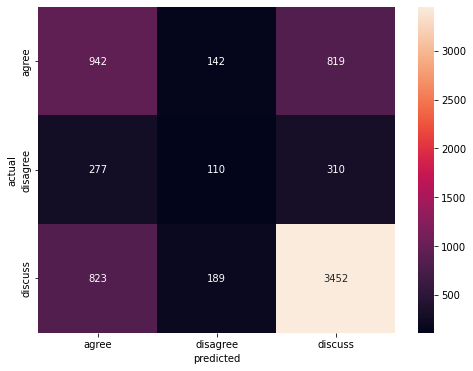

In [ ]:
cwMat = confusion_matrix(testSet['Stance'], preds, labels = [0, 1, 2])
cwDf = pd.DataFrame(cwMat, index=["agree", "disagree", "discuss"], columns=["agree", "disagree", "discuss"])
plt.figure(figsize=(8,6))
sns.heatmap(cwDf, annot=True, fmt="d")
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

### Testing

In [5]:
testStances = pd.read_csv('competition_test_stances.csv')
testBodies = pd.read_csv('competition_test_bodies.csv')
testSet = pd.merge(testStances, testBodies, on="Body ID")

In [8]:
'''
  Accepts a dataframe with following columns - 
  Headline - text data
  articleBody - text data

  returns features which are used to predict unrelated vs others(agree, disagree, discuss)
'''
def convertDataOne(x):
  vectorizer = joblib.load("UnrelatedVsOthersVectorizer")
  x['headTFIDF'] = vectorizer.transform(x['Headline']).toarray().tolist()
  x['articleBodyTFIDF'] = vectorizer.transform(x['articleBody']).toarray().tolist()
  del(x['Headline'])
  del(x['articleBody'])

  p = x['headTFIDF'].tolist()
  q = x['articleBodyTFIDF'].tolist()
  del(x['headTFIDF'])
  del(x['articleBodyTFIDF'])

  # Calculate distances between headline TFIDF and Body TFIDF
  cos = []
  euc = []
  man = []
  for idx, _ in enumerate(p):
    cos.append(cosine_similarity( [p[idx]], [q[idx]])[0][0])
    euc.append(euclidean_distances( [p[idx]], [q[idx]])[0][0])
    man.append(manhattan_distances( [p[idx]], [q[idx]])[0][0])
  x['cos_simil'] = cos
  x['euclidean'] = euc
  x['manhattan'] = man

  return x

'''
  Accepts a dataframe with following columns - 
  Headline - text data
  articleBody - text data

  returns features which are used to predict agree or disagree or discuss
'''
def convertDataTwo(x):
  vectorizer2 = joblib.load("OthersVectorizer")
  x['headTFIDF'] = vectorizer2.transform(x['Headline']).toarray().tolist()
  x['articleBodyTFIDF'] = vectorizer2.transform(x['articleBody']).toarray().tolist()
  x['allTFIDF'] = np.concatenate((x['headTFIDF'].tolist(), x['articleBodyTFIDF'].tolist()), axis=1).tolist()
  del(x['Headline'])
  del(x['articleBody'])
  del(x['headTFIDF'])
  del(x['articleBodyTFIDF'])

  return x


'''
  Accepts a dataframe with following columns - 
  Headline - text data
  articleBody - text data

  returns predictions for the rows in the dataframe
'''
def predictOnData(df):
  x = df.copy(deep=True)
  
  x = convertDataOne(x)
  model1 = joblib.load("UnrelatedVsOthersModel")
  preds = model1.predict(x[['cos_simil', 'euclidean', 'manhattan']])
  preds = [np.argmax(x) for x in preds]
  preds = np.array(preds)
  
  idxs = list(np.where(preds == 1)[0])

  if len(idxs) == 0:
    return list(preds)

  preds = list(preds)

  for i, _ in enumerate(preds):
    if preds[i] == 0:
      preds[i] = 'unrelated'


  
  model2 = joblib.load("OthersModel")
  x = df.copy(deep=True)
  x = x.loc[idxs, :]
 
  x = convertDataTwo(x)
  preds2 = model2.predict(x['allTFIDF'].tolist())
  preds2 = [np.argmax(x) for x in preds2]

  for i,_ in enumerate(preds2):
    if preds2[i] == 0:
      preds2[i] = 'agree'
    elif preds2[i] == 1:
      preds2[i] = 'disagree'
    else:
      preds2[i] = 'discuss'
  
  for i, idx in enumerate(idxs):
    preds[idx] = preds2[i]
  
  

  return preds

In [9]:
preds = predictOnData(testSet)
predictedTest = testSet.copy(deep=True)
predictedTest['Stance'] = preds

In [ ]:
predictedTest.to_csv('predictedTest.csv')
testSet.to_csv('goldTest.csv')

In [10]:
FIELDNAMES = ['Headline', 'Body ID', 'Stance', 'articleBody']
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
RELATED = LABELS[0:3]
USAGE = """
FakeNewsChallenge FNC-1 scorer - version 1.0
Usage: python scorer.py gold_labels test_labels
  gold_labels - CSV file with reference GOLD stance labels
  test_labels - CSV file with predicted stance labels
The scorer will provide three scores: MAX, NULL, and TEST
  MAX  - the best possible score (100% accuracy)
  NULL - score as if all predicted stances were unrelated
  TEST - score based on the provided predictions
"""

ERROR_MISMATCH = """
ERROR: Entry mismatch at line {}
 [expected] Headline: {} // Body ID: {}
 [got] Headline: {} // Body ID: {}
"""

SCORE_REPORT = """
MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions
||    MAX    ||    NULL   ||    TEST   ||\n||{:^11}||{:^11}||{:^11}||
"""

In [11]:
def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, ((_,g), (_,t)) in enumerate(zip(gold_labels.iterrows(), test_labels.iterrows())):
        if g['Headline'] != t['Headline'] or g['Body ID'] != t['Body ID']:
            error = ERROR_MISMATCH.format(i+2,
                                          g['Headline'], g['Body ID'],
                                          t['Headline'], t['Body ID'])
        else:
            g_stance, t_stance = g['Stance'], t['Stance']
            if g_stance == t_stance:
                score += 0.25
                if g_stance != 'unrelated':
                    score += 0.50
            if g_stance in RELATED and t_stance in RELATED:
                score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm

In [12]:
def score_defaults(gold_labels):
    """
    Compute the "all false" baseline (all labels as unrelated) and the max
    possible score
    :param gold_labels: list containing the true labels
    :return: (null_score, best_score)
    """
    unrelated = [g for _,g in gold_labels.iterrows() if g['Stance'] == 'unrelated']
    null_score = 0.25 * len(unrelated)
    max_score = null_score + (len(gold_labels) - len(unrelated))
    return null_score, max_score


In [13]:
def print_confusion_matrix(cm):
    lines = ['CONFUSION MATRIX:']
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    lines.append("ACCURACY: {:.3f}".format(hit / total))
    print('\n'.join(lines))

In [14]:
test_score, cm = score_submission(testSet, predictedTest)
null_score, max_score = score_defaults(testSet)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    721    |    85     |    594    |    503    |
-------------------------------------------------------------
| disagree  |    180    |    54     |    166    |    297    |
-------------------------------------------------------------
|  discuss  |    508    |    94     |   2511    |   1351    |
-------------------------------------------------------------
| unrelated |    203    |    71     |    542    |   17533   |
-------------------------------------------------------------
ACCURACY: 0.819

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions
||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  8076.0   ||

